In [1]:

import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')
from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc

from asap.data.dataloader import DataSet
from scipy.linalg import qr

experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.initialize_data()

print(dl.inpath)
print(dl.outpath)

dl.load_data()

X_rows = dl.mtx.shape[0]
tree_max_depth = 10 

rp_mat = []
for _ in range(tree_max_depth):
    rp_mat.append(np.random.normal(size = (X_rows,1)).flatten())                      
rp_mat = np.asarray(rp_mat)

Z = np.dot(rp_mat,dl.mtx).T
Q, _ = qr(Z,mode='economic')



/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc/pbmc
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc/pbmc


In [2]:
b = [ x.split('_')[1] for x in dl.barcodes]
b3 = [ 1 if x =='3k' else 0 for x in b]
b4 = [ 1 if x =='4k' else 0 for x in b]
batch = np.array([b3,b4]).T


In [3]:
from sklearn.preprocessing import StandardScaler

Q_scaled = StandardScaler().fit_transform(Q)
u, s, _ = np.linalg.svd(batch, full_matrices=True)
Qres = Q_scaled - u@u.T@Q_scaled


(array([161.,  49.,  41.,  33.,  28.,  44.,  29.,  20.,  24.,  67.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

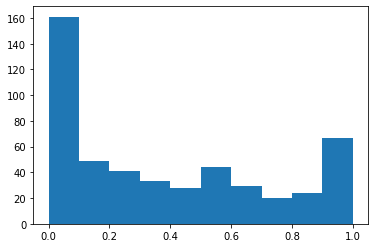

In [17]:
Qt = (np.sign(Q) + 1)/2

df = pd.DataFrame(Qt,dtype=int)
df['code'] = df.astype(str).agg(''.join, axis=1)
df = df.reset_index()
df = df[['index','code']]
pbulkd = df.groupby('code').agg(lambda x: list(x)).reset_index().set_index('code').to_dict()['index']
mix_res = []
for k in pbulkd.keys():
    mix = np.array(b)[pbulkd[k]]
    mix_res.append(len(mix[mix=='3k'])/len(mix))
plt.hist(mix_res)

In [18]:
df.code.value_counts()

0111010010    82
0001001011    68
0001111110    67
0001001010    57
0111110010    57
              ..
0101100100     1
0101010100     1
0010110110     1
0101000110     1
0010010110     1
Name: code, Length: 496, dtype: int64

In [20]:
mix = np.array(b)[pbulkd['0111110010']]
mix

array(['3k', '3k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k'], dtype='<U2')

(array([226.,   1.,   1.,   1.,   0.,   6.,   0.,   0.,   0., 200.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

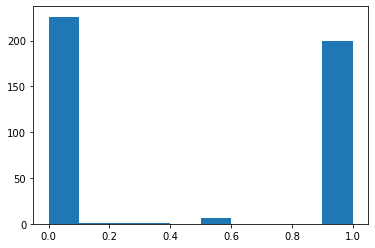

In [4]:
Qt_res = (np.sign(Qres) + 1)/2

df = pd.DataFrame(Qt_res,dtype=int)
df['code'] = df.astype(str).agg(''.join, axis=1)
df = df.reset_index()
df = df[['index','code']]
pbulkd = df.groupby('code').agg(lambda x: list(x)).reset_index().set_index('code').to_dict()['index']
mix_res = []
for k in pbulkd.keys():
    mix = np.array(b)[pbulkd[k]]
    mix_res.append(len(mix[mix=='3k'])/len(mix))
plt.hist(mix_res)

In [6]:
pbulk = {}
for key, value in pbulkd.items():
    pbulk[key] = dl.mtx[:,value].sum(1)

df= pd.DataFrame.from_dict(pbulk,orient='index')

In [8]:
pbulk_mat = df.to_numpy().T
np.savez(sample_out+'_pbulk.npz', pbulk= pbulk_mat)

In [7]:
df.code.value_counts()

0001101111    455
1110010000    422
0000101111    420
0001101110    357
0000101110    325
             ... 
1011000100      1
1010001011      1
1110011111      1
1011000011      1
1000100111      1
Name: code, Length: 564, dtype: int64

In [12]:
mix = np.array(b)[pbulkd['0000101111']]
mix

array(['4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4k',
       '4k', '4k', '4k', '4k', '4k', '4k', '4k', '4

In [ ]:
from sklearn.decomposition import PCA

	
# data scaling
x_scaled = StandardScaler().fit_transform(dl.mtx.T)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_scaled)
df_pca = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2'])

In [ ]:
df_pca['batch'] = [x.split('_')[1] for x in dl.barcodes]
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_pca['batch'].unique()))
p = sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='batch',s=5,palette=cp,legend=True)

In [ ]:
dft = pd.DataFrame(Q[:,:2],columns=['PC1','PC2'])
dft['batch'] = [x.split('_')[1] for x in dl.barcodes]
p = sns.scatterplot(data=dft, x='PC1', y='PC2', hue='batch',s=5,palette=cp,legend=True)

In [ ]:
dl.mtx.shape

In [ ]:
### run pca here -->



Q = (np.sign(Q) + 1)/2

df = pd.DataFrame(Q,dtype=int)
df['code'] = df.astype(str).agg(''.join, axis=1)
df = df.reset_index()
df = df[['index','code']]
pbulkd = df.groupby('code').agg(lambda x: list(x)).reset_index().set_index('code').to_dict()['index']

pbulk = {}
for key, value in pbulkd.items():
    pbulk[key] = mtx[:,value].sum(1)

pd.DataFrame.from_dict(pbulk,orient='index')


from asap.annotation import ASAPNMF
asap = ASAPNMF(adata=dl)
asap.get_pbulk()

In [ ]:
nz_cutoff = 10
dfall = dfall[dfall.iloc[:,2:].sum(1)>nz_cutoff].reset_index(drop=True)
genes = dfall['gene'].values
glens = dfall['length'].values
dfall = dfall.drop(columns=['gene','length'])


qt = QuantileTransformer(random_state=0)
dfall_q = qt.fit_transform(dfall)

mu_total = np.mean(dfall_q,axis=1)
 
scaler = StandardScaler()
dfall_q = pd.DataFrame(scaler.fit_transform(dfall_q.T).T,columns=dfall.columns)


u,d,v = skrsvd(dfall_q.to_numpy()/np.sqrt(dfall_q.shape[1]),n_components=50,random_state=0)
L_total = u * d

In [ ]:
def get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct):
    z_total = np.dot(L_total,np.random.normal(size=L_total.shape[1])) + mu_total
    z_ct = np.dot(L_ct,np.random.normal(size=L_ct.shape[1])) + mu_ct
    x_sample = np.sort(dfct.apply(lambda x: np.random.choice(x), axis=1))
    z_sample = np.array([np.nan] * len(x_sample))
    z = z_ct * np.sqrt(pve_ct) + z_total * np.sqrt(1 - pve_ct)
    z_sample[np.argsort(z)] = x_sample
    return z_sample


In [ ]:
ct_prop = {'NK':7.4,
 'THSTAR':2.1,
 'TH1':1.5,
 'B_CELL_NAIVE':5.2,
 'TREG_MEM':1.2,
 'TH2':1.9,
 'TREG_NAIVE':0.4,
 'MONOCYTES':17.7,
 'M2':1.6,
 'TFH':2.7,
 'CD8_NAIVE':6.4,
 'CD4_NAIVE':11,
 'TH17':3.2
}

In [ ]:
size= 2
pve_ct = 0.99
all_indx = []
dfsc = pd.DataFrame()
for ct in cts:
    dfct = dfall[[x for x in dfall.columns if ct in x]]
    dfct_q = dfall_q[[x for x in dfall_q.columns if ct in x]]

    mu_ct = dfct_q.mean(1)

    scaler = StandardScaler()
    dfct_q = pd.DataFrame(scaler.fit_transform(dfct_q.T).T)

    u,d,v = rsvd(dfct_q.to_numpy()/np.sqrt(dfct_q.shape[1]),n_components=50,random_state=0)
    L_ct = u * d

    ct_sc = []
    for i in range(size):
        ct_sc.append(get_sc(L_total,mu_total,dfct,L_ct,mu_ct,pve_ct))
    df_ctsc = pd.DataFrame(ct_sc,columns=genes)

    dfsc = pd.concat([dfsc,df_ctsc],axis=0,ignore_index=True)
    all_indx.append([ str(i) + '_' + ct.replace(' ','') for i in range(size)])

    print(ct)

In [ ]:
dfsc.index = np.array(all_indx).flatten()
dfsc

In [ ]:
# sns.scatterplot(x=np.log(dfsc.loc['0_NK']),y=np.log(dfsc.loc['1_NK']),s=2)
sns.scatterplot(x=np.log(dfsc.loc['1_NK']),y=np.log(dfsc.loc['0_M2']),s=2)